In [952]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import trange
%config InlineBackend.figure_formats = ['svg']

In [953]:
# df = pd.read_csv('sac_cryosig.csv', index_col=0)
df = pd.read_csv('sweep_cryosig.csv', index_col=0)
df

,Channel,Time (h),Pulse height (V),RMS (V),Test pulse amplitude (V),DAC output (V),Bias current (muA),TES resistance / normal conducting
0,1.0,0.001389,0.000012,0.000003,0.1,5.00,0.1,1.0
1,1.0,0.002778,0.000011,0.000003,0.5,4.99,0.1,1.0
2,1.0,0.004167,0.000011,0.000003,1.0,4.98,0.1,1.0
3,1.0,0.005556,0.000013,0.000003,2.0,4.97,0.1,1.0
4,1.0,0.006944,0.000012,0.000003,3.0,4.96,0.1,1.0
...,...,...,...,...,...,...,...,...
495,1.0,0.688889,0.000026,0.000007,2.0,0.05,0.1,0.0
496,1.0,0.690278,0.000027,0.000007,3.0,0.04,0.1,0.0
497,1.0,0.691667,0.000029,0.000007,4.0,0.03,0.1,0.0
498,1.0,0.693056,0.000028,0.000007,5.0,0.02,0.1,0.0


In [954]:
print('DAC Q1: ', df['DAC output (V)'][np.argmax(df['TES resistance / normal conducting'] < 0.25)])
print('DAC Q2: ', df['DAC output (V)'][np.argmax(df['TES resistance / normal conducting'] < 0.5)])
print('DAC Q3: ', df['DAC output (V)'][np.argmax(df['TES resistance / normal conducting'] < 0.75)])
first_line = df['DAC output (V)'][np.argmax(df['TES resistance / normal conducting']*0.2 < 0.035)]
print('DAC TES < Shunt: ', first_line)
second_line = df['DAC output (V)'][np.argmax(df['TES resistance / normal conducting'] < 0.001)]
print('DAC TES = 0: ', second_line)

DAC Q1:  1.110000000000083
DAC Q2:  1.2600000000000795
DAC Q3:  1.4200000000000763
DAC TES < Shunt:  1.0500000000000842
DAC TES = 0:  0.8000000000000895


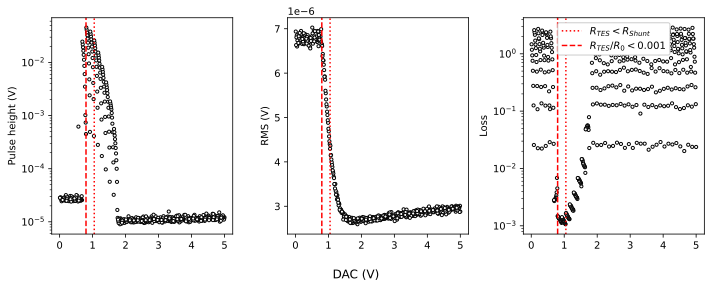

In [955]:
fig, ax = plt.subplots(1,3, dpi=150, figsize=(10,4))

for tpa in np.unique(df['Test pulse amplitude (V)']):
    ax[0].scatter(df['DAC output (V)'][df['Test pulse amplitude (V)'] == tpa], 
                df['Pulse height (V)'][df['Test pulse amplitude (V)'] == tpa], s=10, marker='o', #label=str(tpa), 
                color='white', edgecolor='black')
ax[0].set_yscale('log')
ax[0].set_ylabel('Pulse height (V)')

for tpa in np.unique(df['Test pulse amplitude (V)']):
    ax[1].scatter(df['DAC output (V)'][df['Test pulse amplitude (V)'] == tpa], 
                df['RMS (V)'][df['Test pulse amplitude (V)'] == tpa], s=10, marker='o', #label=str(tpa), 
                color='white', edgecolor='black')
# ax[1].set_yscale('log')
ax[1].set_ylabel('RMS (V)')

for tpa in np.unique(df['Test pulse amplitude (V)']):
    ax[2].scatter(df['DAC output (V)'][df['Test pulse amplitude (V)'] == tpa], 
                df['RMS (V)'][df['Test pulse amplitude (V)'] == tpa]*df['Test pulse amplitude (V)'][df['Test pulse amplitude (V)'] == tpa]/df['Pulse height (V)'][df['Test pulse amplitude (V)'] == tpa], s=10, marker='o', #label=str(tpa), 
                color='white', edgecolor='black')
ax[2].set_yscale('log')
ax[2].set_ylabel('Loss')

for i in range(3):
    label = '$R_{TES} < R_{Shunt}$' if i == 2 else ''
    ax[i].axvline(first_line, color='red', linestyle='dotted', label=label)
    label = '$R_{TES}/R_{0} < 0.001$' if i == 2 else ''
    ax[i].axvline(second_line, color='red', linestyle='dashed', label=label)
    
ax[2].legend(loc='upper center', framealpha=1)
    
fig.supxlabel('DAC (V)')
fig.tight_layout()
plt.savefig('results/sweep_loss.png')
plt.show()

In [630]:
rewards = []
smooth = 1

plt.figure(dpi=150, figsize=(6,4))

for name in ['sac_cryosig.csv', 
             'sac_cryosig_1.csv', 
             'sac_cryosig_2.csv',
            ]:
    df = pd.read_csv(name, index_col=0)

    rwd = - df['Test pulse amplitude (V)'] * df['RMS (V)'] / df['Pulse height (V)']
    rwd = np.mean(np.array(rwd[:smooth*(rwd.shape[0]//smooth)]).reshape(-1, smooth), axis=-1)
    rewards.append(rwd)

rewards = np.array(rewards)

x_axis = 5*smooth*np.arange(rewards.shape[1])/60

plt.plot(x_axis, - np.mean(rewards, axis=0), color='green')
plt.fill_between(x_axis, 
                 ( - (np.mean(rewards, axis=0) + np.std(rewards, axis=0))), 
                 ( - (np.mean(rewards, axis=0) - np.std(rewards, axis=0))),
                 alpha=0.3, color='green')
# plt.ylim(-0.5, 0.01)
plt.yscale('log')
plt.ylabel('Average loss (smoothed over {} steps)'.format(smooth))
plt.xlabel('Elapsed measurement time (mins)')
plt.tight_layout()
plt.show()

<ipython-input-630-bfea5e61b66a>:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  rewards = np.array(rewards)


IndexError: tuple index out of range

<Figure size 900x600 with 0 Axes>

In [194]:
x = np.load('sac_cryosig.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'sac_cryosig.npy'

1.0


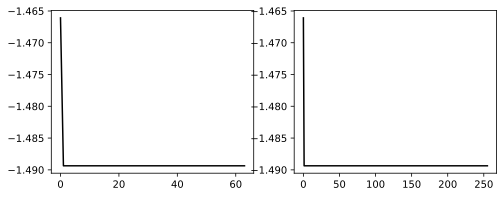

In [184]:
idx = 0

print(df['TES resistance / normal conducting'][idx])

fig, ax = plt.subplots(1,2, figsize=(8,3))
ax[0].plot(x[idx, :64], color='black')
#ax[0].set_ylim(-0.000001,0.000001)
ax[1].plot(x[idx], color='black')
#ax[1].set_ylim(-0.001,0.25)
plt.show()

In [2]:
ls = 'bck_009 bck_010 bck_011 bck_012 bck_013 bck_014 bck_016 bck_017 bck_019 bck_020 bck_021 bck_022 bck_024 bck_025 bck_026 bck_027 bck_030 bck_031 bck_032 bck_034 bck_036 bck_037 bck_038 bck_045 bck_046 bck_047 bck_049 bck_050 bck_051 bck_052 bck_053 bck_054 bck_055 bck_056 bck_057 bck_060 bck_061 bck_062 bck_066 bck_067 bck_070 bck_071 bck_072 bck_073 bck_074 bck_077 bck_079 bck_080 bck_081 bck_082 bck_083 bck_084 bck_085 bck_086 bck_087 bck_088 bck_090 bck_091 bck_092 bck_093 bck_094 bck_095 bck_096 bck_097 bck_098 bck_099 bck_100 bck_101 bck_120 bck_121 bck_122 bck_123 bck_124 bck_125 bck_127 bck_128 bck_129 bck_130 bck_131'

In [8]:
ls = [x[4:] for x in ls.split(' ')]

In [13]:
s = ''
for l in ls:
    s += ' ' + l
s = s[1:]

In [14]:
s

'009 010 011 012 013 014 016 017 019 020 021 022 024 025 026 027 030 031 032 034 036 037 038 045 046 047 049 050 051 052 053 054 055 056 057 060 061 062 066 067 070 071 072 073 074 077 079 080 081 082 083 084 085 086 087 088 090 091 092 093 094 095 096 097 098 099 100 101 120 121 122 123 124 125 127 128 129 130 131'